<a href="https://colab.research.google.com/github/Denis-R-V/TSR/blob/main/sign_detector_augmentated_v1_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Denis-R-V/TSR/blob/main/sign_detector.ipynb)

# Система распознавания дорожных знаков на датасете RTSD

In [1]:
colab = False

if colab == True:
    from google.colab import drive
    drive.mount('/content/drive')
    !pip install kaggle
    !mkdir ~/.kaggle
    !cp /content/drive/MyDrive/kaggle.json ~/.kaggle/kaggle.json
    
    !kaggle datasets download watchman/rtsd-dataset
    !unzip rtsd-dataset.zip
    !rm rtsd-dataset.zip
    !cp -r rtsd-frames/rtsd-frames/ .
    !rm -r rtsd-frames/rtsd-frames/

    !kaggle datasets download meowmeowmeowmeowmeow/gtsrb-german-traffic-sign
    !unzip gtsrb-german-traffic-sign.zip -d GTSRB/
    !rm gtsrb-german-traffic-sign.zip

    !kaggle datasets download mahadevkonar/belgiumts-dataset
    !unzip belgiumts-dataset.zip -d BelgiumTSC/
    !rm belgiumts-dataset.zip

    !kaggle datasets download dmitryyemelyanov/chinese-traffic-signs
    !unzip chinese-traffic-signs.zip -d ChineseTS/
    !rm chinese-traffic-signs.zip

    !cp /content/drive/MyDrive/TSR/train_anno_reduced_fp_detections.json .
    !cp /content/drive/MyDrive/TSR/val_anno_fp_detections.json .
    !cp /content/drive/MyDrive/TSR/train_anno_reduced_background.json .
    !cp /content/drive/MyDrive/TSR/val_anno_background.json .
    !cp /content/drive/MyDrive/TSR/RTSD_train_exp.pkl .

    !pip install fiftyone

if colab == True:
    dataset_path = '.'
    checkpoints_path = '../content/drive/MyDrive/TSR/checkpoints'
else:
    dataset_path = 'data'
    checkpoints_path = 'checkpoints'

import os
import json
import numpy as np 
import pandas as pd 

from PIL import Image
import matplotlib.pyplot as plt
#import matplotlib.patches as patches
#%matplotlib inline

#from pycocotools.coco import COCO
#import fiftyone as fo
import time
import torch
import torch.nn as nn
#import torchvision
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms
#from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
#from torchvision.models.detection import FasterRCNN
from torchvision.models import resnet152
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
from sklearn import metrics
from torchvision import models
#import cv2
#PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0

## Обучение модели

### Загрузчик данных

In [ ]:
'''# Удаление категорий с количеством знаков меньше порога
sign_threshold = 10
filt = lambda x: x.sign.count() > sign_threshold
RTSD_train_exp_lim = RTSD_train_exp.groupby('category_id').filter(filt)

print("Количество уникальных категорий: {}".format(len(RTSD_train_exp.category_id.unique())))
RTSD_train_exp_lim'''

In [2]:
# Загрузка аннотации обучающей выборки (расширенной)
anno_train = pd.read_pickle(os.path.join(dataset_path, 'RTSD_train_exp.pkl'))  
anno_train

,file_name,source,width,height,bbox,category_id,sign,sign_name
0,rtsd-frames/autosave01_02_2012_09_16_49.jpg,RTSD_train,1280,720,"[763, 307, 800, 372]",0,0,Background
1,rtsd-frames/autosave16_10_2012_07_15_14_0.jpg,RTSD_train,1280,720,"[968, 292, 992, 314]",0,0,Background
2,rtsd-frames/autosave16_10_2012_07_15_14_0.jpg,RTSD_train,1280,720,"[781, 234, 875, 320]",0,0,Background
3,rtsd-frames/autosave16_10_2012_07_15_14_1.jpg,RTSD_train,1280,720,"[763, 186, 790, 217]",0,0,Background
4,rtsd-frames/autosave16_10_2012_07_15_14_1.jpg,RTSD_train,1280,720,"[758, 186, 800, 236]",0,0,Background
...,...,...,...,...,...,...,...,...
133818,rtsd-frames/autosave24_10_2013_11_23_19_2.jpg,RTSD_train,1280,720,"[767, 306, 806, 366]",154,7_14,Пункт транспортного контроля
133819,rtsd-frames/autosave24_10_2013_11_23_20_1.jpg,RTSD_train,1280,720,"[1143, 101, 1255, 252]",154,7_14,Пункт транспортного контроля
133820,rtsd-frames/autosave24_10_2013_11_29_00_0.jpg,RTSD_train,1280,720,"[762, 367, 798, 384]",155,8_23,Фотовидеофиксация
133821,rtsd-frames/autosave24_10_2013_11_29_00_1.jpg,RTSD_train,1280,720,"[878, 346, 934, 372]",155,8_23,Фотовидеофиксация


In [4]:
# Загрузка аннотации тестовой выборки
with open(os.path.join(dataset_path, 'val_anno.json'), 'r') as read_file:
    val_anno_json = json.load(read_file)
read_file.close()

anno_val = pd.DataFrame(val_anno_json.get('annotations'))
anno_images_val = pd.DataFrame(val_anno_json.get('images'))
anno_val = anno_val.merge(anno_images_val, left_on='image_id', right_on='id')[['file_name', 'width', 'height', 'bbox','category_id']]

# Приведение bbox из формата COCO (x1, y1, w, h) к виду (x1, y1, x2, y2)
anno_val['bbox'] = anno_val['bbox'].apply (lambda x: [x[0], x[1], x[0] + x[2], x[1] + x[3]])

# Добавим вспомогательную колонку с источником изображения (датасет)
anno_val.insert(1, 'source', 'RTSD_test')

# Добавим для визуалиции labels
with open(os.path.join(dataset_path, 'label_map.json'), 'r') as read_file:
    label_map = json.load(read_file)
read_file.close()

anno_val = anno_val.merge(pd.DataFrame([label_map]).T.reset_index().set_index(0), left_on='category_id', right_index=True)
anno_val.rename(columns={'index':'sign'}, inplace=True)

# Добавим столбец с наименованием знака
with open(os.path.join(dataset_path, 'labels_names_map.json'), 'r') as read_file:
    labels_names_map = json.load(read_file)
read_file.close()

anno_val = anno_val.merge(pd.DataFrame([labels_names_map]).T, left_on='sign', right_index=True)
anno_val.rename(columns={0:'sign_name'}, inplace=True)

anno_val

,file_name,source,width,height,bbox,category_id,sign,sign_name
0,rtsd-frames/autosave10_10_2012_13_50_36_1.jpg,RTSD_test,1280,720,"[622, 375, 652, 402]",3,1_17,Искусственная неровность
53,rtsd-frames/autosave16_04_2013_15_11_26_1.jpg,RTSD_test,1920,1080,"[1050, 436, 1079, 459]",3,1_17,Искусственная неровность
61,rtsd-frames/autosave16_04_2013_13_19_50_2.jpg,RTSD_test,1920,1080,"[1033, 506, 1076, 546]",3,1_17,Искусственная неровность
78,rtsd-frames/autosave13_04_2013_11_07_29_0.jpg,RTSD_test,1920,1080,"[1185, 380, 1221, 415]",3,1_17,Искусственная неровность
90,rtsd-frames/autosave16_04_2013_13_19_50_0.jpg,RTSD_test,1920,1080,"[979, 530, 1014, 558]",3,1_17,Искусственная неровность
...,...,...,...,...,...,...,...,...
7311,rtsd-frames/autosave16_04_2013_13_34_06_2.jpg,RTSD_test,1920,1080,"[1192, 838, 1222, 866]",147,1_26,Перегон скота
8035,rtsd-frames/autosave24_10_2013_11_21_12_0.jpg,RTSD_test,1280,720,"[869, 350, 894, 390]",153,7_18,Туалет
8126,rtsd-frames/autosave10_10_2012_09_29_51_1.jpg,RTSD_test,1280,720,"[781, 333, 812, 362]",133,5_12,Конец дороги с полосой для маршрутных транспор...
8436,rtsd-frames/autosave16_10_2012_08_36_42_0.jpg,RTSD_test,1280,720,"[820, 316, 843, 358]",149,6_8_1,Тупик (прямо)


In [5]:
class RTSD_extended_classifier(Dataset):
    def __init__(self, dataset_path, annotation, transforms, sampling=False, samples_in_class=None):
        
        self.dataset_path = dataset_path
        self.dataset = annotation
        self.transforms = transforms
        self.transforms_lib = None
        try:
            self.transforms.additional_targets == {}
            self.transforms_lib = 'albumentations'
        except:
            self.transforms_lib = 'torchvision'

        # Функция балансировки классов равным количество сэмплов
        if sampling == True:
            dataset_new = pd.DataFrame(columns = self.dataset.columns)
            categories = list(self.dataset.category_id.unique())
            if samples_in_class is None:
                samples_in_class = self.dataset.category_id.value_counts().max()
            for category in categories:
                category_id = int(category)
                df_cat_orig = self.dataset[self.dataset['category_id'] == category_id].copy()
                df_cat_sampled = pd.DataFrame(columns = self.dataset.columns)
                if samples_in_class//len(df_cat_orig) > 0:
                    for i in range(samples_in_class//len(df_cat_orig)):
                        df_cat_sampled = pd.concat((df_cat_sampled, df_cat_orig))
                if len(df_cat_sampled) < samples_in_class:
                    samples = df_cat_orig.sample(n=(samples_in_class - len(df_cat_sampled)), replace=True)
                    df_cat_sampled = pd.concat((df_cat_sampled, samples))    
                dataset_new = pd.concat((dataset_new, df_cat_sampled))
            dataset_new.reset_index(inplace=True)
            del dataset_new['index']
            self.dataset = dataset_new

        # вариант с codecamp
        #dataset.groupby('category_id', group_keys= False).apply(lambda x: x.sample(2, replace=True))

    def __len__(self):
        return self.dataset.shape[0]

    def __getitem__(self, index):
        img_name = self.dataset.loc[index,'file_name']
        bbox = self.dataset.loc[index,'bbox']
        
        if (self.dataset.loc[index,'source'] == 'RTSD_train') or (self.dataset.loc[index,'source'] == 'RTSD_test'):
            #width = self.dataset.loc[index,'width']
            #height = self.dataset.loc[index,'height']
            sign_w = bbox[2] - bbox[0]
            sign_h = bbox[3] - bbox[1]
            x1 = max(bbox[0] - round(max((sign_w*0.05), 5)), 0)
            y1 = max(bbox[1] - round(max((sign_h*0.05), 5)), 0)
            x2 = min(bbox[2] + round(max((sign_w*0.05), 5)), self.dataset.loc[index,'width'])
            y2 = min(bbox[3] + round(max((sign_h*0.05), 5)), self.dataset.loc[index,'height'])
            bbox = [x1, y1, x2, y2]

        img = Image.open(os.path.join(self.dataset_path, img_name))
        img = img.crop(bbox)
        
        if self.transforms_lib == 'torchvision':
            img = self.transforms(img)
        elif self.transforms_lib == 'albumentations':
            img = np.array(img).astype(np.float32)/255.
            img = self.transforms(image=img)['image']
            img = img.float()
        else:
            print('Ошибка выбора библиотеки аугментации')

        label = torch.tensor(self.dataset.loc[index,'category_id'])
    
        
        #from PIL import ImageOps
        #old_img = Image.open(image_path)
        # создание нового изображения с белым фоном
        #new_image = ImageOps.expand(old_img, border=25, fill=(255,255,255))

        return {'images':img, 'labels':label}

In [6]:
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
    # Send train=True fro training transforms and False for val/test transforms
def get_transform(augmentation_lib = 'torchvision', train=False):
    if augmentation_lib =='torchvision':
        if train == True:
            return transforms.Compose([transforms.Resize((224,224)),
                                       transforms.RandomPerspective(distortion_scale=0.4,p=0.7),
                                       transforms.ToTensor(),
                                       transforms.ColorJitter(brightness=(0.5), contrast=(0.4), saturation=(0.4)),
                                       transforms.GaussianBlur(11, sigma=(0.1, 2.0)),
                                       transforms.RandomAdjustSharpness(5),
                                       transforms.RandomRotation(10),
                                       transforms.RandomResizedCrop((224,224), scale=(0.85, 1)), # Случайная обрезка изображения в диапахоне 85 - 100% и resize в исходный размер
                                       #transforms.Normalize([0.485, 0.456, 0.406],      # 1 496
                                       #                     [0.229, 0.224, 0.225]),
                                       transforms.RandomErasing(p = 0.4, scale = (0.003, 0.1)),
                                       transforms.RandomErasing(p = 0.6, scale = (0.003, 0.05)),
                                       transforms.RandomErasing(p = 0.6, scale = (0.003, 0.05)),
                                       transforms.RandomErasing(p = 0.6, scale = (0.003, 0.02)),
                                       transforms.RandomErasing(p = 0.6, scale = (0.003, 0.02)),
                                       transforms.RandomErasing(p = 0.6, scale = (0.001, 0.01)),
                                       transforms.RandomErasing(p = 0.6, scale = (0.001, 0.01)),
                                       transforms.RandomErasing(p = 0.6, scale = (0.001, 0.01)),
                                       transforms.RandomErasing(p = 0.6, scale = (0.001, 0.01)),
                                       transforms.RandomErasing(p = 0.6, scale = (0.001, 0.01)),
                                       ])
        else:
            return transforms.Compose([transforms.Resize((224,224)),
                                       transforms.ToTensor(),
                                       #transforms.Normalize([0.485, 0.456, 0.406],      # 1 496
                                       #                     [0.229, 0.224, 0.225])
                                       ])   
    
    elif augmentation_lib =='albumentations':
        if train==True:
            return A.Compose([A.augmentations.geometric.resize.Resize (224, 224, interpolation=1, always_apply=False, p=1),
                              A.augmentations.transforms.GaussNoise (var_limit=(0.01, 0.05), mean=0, per_channel=False, always_apply=False, p=0.3),
                              A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3, p=0.8),
                              A.RandomFog(fog_coef_lower=0.2, fog_coef_upper=0.3, alpha_coef=0.1, p=0.05), #Туман
                              A.RandomRain(brightness_coefficient=0.9, drop_width=1, blur_value=5, p=0.05),
                              A.Rotate(limit=10, p=0.5),
                              ToTensorV2(p=1.0)
                              ])
            
        else:
            return A.Compose([A.augmentations.geometric.resize.Resize (224, 224, interpolation=1, always_apply=False, p=1),
                              ToTensorV2(p=1.0)
                              ])

In [340]:
test_tvs = RTSD_extended_classifier(dataset_path,
                                  annotation = anno_train,
                                  transforms = get_transform(augmentation_lib = 'torchvision', train=True),
                                  sampling=True,
                                  samples_in_class = 10
                                  )

11

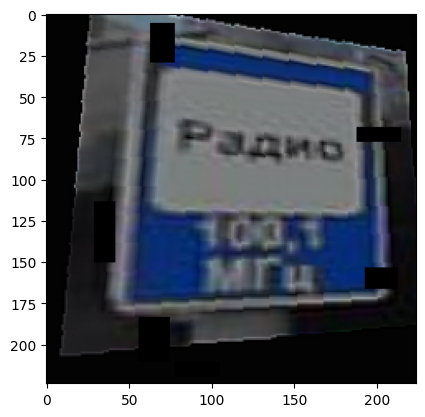

In [344]:
def plot_sign(dataset, index):
    item = dataset.__getitem__(index)
    img = item['images']
    target = item['labels']
    #img, target = test.__getitem__(index)
    img = img.permute(1, 2, 0).detach().numpy()
    img = img*255
    img = img.astype(np.uint8)
    fig, a = plt.subplots(1,1)
    #fig.set_size_inches(10,10)
    display(int(target.cpu().detach().numpy()))
    a.imshow(img)
    return None
plot_sign(test_1, 111)

In [373]:
test_alb = RTSD_extended_classifier(dataset_path,
                                    annotation = anno_train,
                                    transforms = get_transform(augmentation_lib = 'albumentations', train=True),
                                    sampling=True,
                                    samples_in_class = 10
                                    )

90

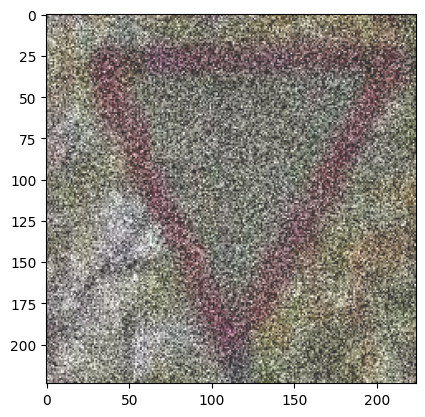

In [383]:
def plot_sign(dataset, index):
    item = dataset.__getitem__(index)
    img = item['images']
    target = item['labels']
    #img, target = test.__getitem__(index)
    img = img.permute(1, 2, 0).detach().numpy()
    img = img*255
    img = img.astype(np.uint8)
    fig, a = plt.subplots(1,1)
    #fig.set_size_inches(10,10)
    display(int(target.cpu().detach().numpy()))
    a.imshow(img)
    return None
plot_sign(test_alb, 904)

### Гиперпараметры

In [39]:
device_id = 0
if torch.cuda.is_available() == True:
    device = f'cuda:{device_id}'
elif torch.backends.mps.is_available() == True:
    device = 'mps'
else:
    device = 'cpu'

model_name = 'resnet152_sampled_full_tvs_adam_001'
last_epoch = None
n_epochs = 20
batch_size = 32
num_classes = 156

device

'cuda:0'

### Инициализация модели, задание оптимизатора и функции потерь

In [20]:
def create_model(num_classes):
    model = resnet152(weights='ResNet152_Weights.IMAGENET1K_V2')
    for param in model.parameters():
        param.requires_grad = False
    
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    #model.fc = nn.Sequential(nn.Linear(2048, 1024), nn.Linear(1024, num_classes))
    #model.fc = nn.Sequential(nn.Linear(2048, num_classes))
    for param in model.fc.parameters():
        param.requires_grad = True

    return model

In [ ]:
#checkpoint = torch.load(os.path.join(checkpoints_path, f'chkpt_classifier_{model_name}_{last_epoch}.pth'), map_location=device)
#checkpoint.keys()

In [40]:
model = create_model(num_classes).to(device)

loss_function = nn.CrossEntropyLoss()

# parameters
params = [p for p in model.parameters() if p.requires_grad]
#optimizer = torch.optim.SGD(params, lr=0.001, momentum=0.9, weight_decay=0.0005)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
#optimizer = torch.optim.SGD(model.parameters(), lr=1e-3, momentum=0.9, weight_decay=0.0005)
#optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=0.0005)
#optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
    # and a learning rate scheduler
#lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)
#lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.9)
#scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.9)


# Загрузка весов модели, состояния оптимизатора и шедулера
if last_epoch is not None:
    checkpoint = torch.load(os.path.join(checkpoints_path, f'chkpt_classifier_{model_name}_{last_epoch}.pth'), map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    lr_scheduler.load_state_dict(checkpoint['lr_scheduler_state_dict'])

train_dataset = RTSD_extended_classifier(dataset_path,
                                         annotation = anno_train,
                                         transforms = get_transform(augmentation_lib = 'torchvision', train=True),
                                         sampling=True,
                                         samples_in_class = 500
                                         )

val_dataset = RTSD_extended_classifier(dataset_path,
                                       annotation = anno_val,
                                       transforms = get_transform(augmentation_lib = 'torchvision', train=False)
                                       )

train_data_loader = DataLoader(
                                train_dataset,
                                #sampler=SubsetRandomSampler(),
                                batch_size=batch_size,
                                shuffle=True,
                                #num_workers=4,
                                #collate_fn=collate_fn
                            )

val_data_loader = DataLoader(
                            val_dataset,
                            #sampler=SubsetRandomSampler(),
                            batch_size=batch_size,
                            shuffle=False,
                            #num_workers=4,
                            #collate_fn=collate_fn
                        )

### Трейн луп

In [31]:
def train(train_dataloader, epoch): 
    len_dataloader = len(train_dataloader)

    training_loss=0
    # для текущего accuracy
    correct = 0.0
    total = 0.0
    # для вывода метрик
    y_true = []
    y_pred = []

    model.train()
    running_loss = 0        # training_loss
    
    for batch_idx, data in enumerate(train_dataloader):
        
        
        
        optimizer.zero_grad()
        #images, targets = data[0], data[1]
        #images = images.to(device)
        #targets = targets.to(device)
        images = data['images'].to(device)
        targets = data['labels'].to(device)
        output = model(images)
        loss = loss_function(output, targets)
        loss.backward()
        optimizer.step()
       
        running_loss = running_loss + ((1/(batch_idx+1))*(loss.data-running_loss))
        if batch_idx%20 == 0:
            print(f"Batch Id {batch_idx}/{len_dataloader} is having training loss of {running_loss}")
            print(loss.item())

        pred = output.data.max(1,keepdim=True)[1]

        # для текущего accuracy
        correct += np.sum(np.squeeze(pred.eq(targets.data.view_as(pred))).cpu().numpy())
        total += images.size(0)
        print(f"Epoch #{epoch}. Accuracy on batch {batch_idx}/{len_dataloader}  on Training is {(100*correct/total)}")
        
        # для вывода метрик
        y_true.extend([int(item) for item in targets])
        y_pred.extend([int(item) for item in pred])

        #images = list(image.to(device) for image in images)
        #targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        #loss_dict = model(images, targets)
        #loss = sum(loss for loss in loss_dict.values())
        #running_loss += loss.item()
        #loss.backward()
        #optimizer.step()
        #if batch_idx % 50 == 0:
        #    print(f"\tЭпоха {epoch}. Итерация {batch_idx}/{len_dataloader}. Loss: {loss}")
    train_loss = running_loss/len(train_dataloader.dataset)
    train_accuracy = metrics.accuracy_score(y_true, y_pred)
    train_f1_micro = metrics.f1_score(y_true, y_pred, average="micro")
    train_f1_macro =  metrics.f1_score(y_true, y_pred, average="macro")
    train_f1_weighted = metrics.f1_score(y_true, y_pred, average="weighted")
    return train_loss, train_accuracy, train_f1_micro, train_f1_macro, train_f1_weighted

In [32]:
def val (val_dataloader, epoch):
    len_dataloader = len(val_dataloader)

    validation_loss=0
    # для текущего accuracy
    correct = 0.0
    total = 0.0
    # для вывода метрик
    y_true = []
    y_pred = []

    model.eval()

    for batch_idx, data in enumerate(val_dataloader):
        
        
        optimizer.zero_grad()
        #images, targets = data[0], data[1]
        #images = images.to(device)
        #targets = targets.to(device)
        images = data['images'].to(device)
        targets = data['labels'].to(device)
        #with torch.no_grad():
            
        output = model(images)
        loss = loss_function(output, targets)
        
        validation_loss = validation_loss + ((1/(batch_idx+1))*(loss.data-validation_loss))
        #if batch_idx%20 == 0:
        print(f"Epoch #{epoch}. Batch Id {batch_idx}/{len_dataloader}  is having validation loss of {validation_loss}")
        print(loss.item())
        pred = output.data.max(1,keepdim=True)[1]

        # для текущего accuracy
        correct += np.sum(np.squeeze(pred.eq(targets.data.view_as(pred))).cpu().numpy())
        total += images.size(0)
        print(f"Epoch #{epoch}. Batch Id {batch_idx}/{len_dataloader}  is having validation accuracy of {(100*correct/total)}")

        # для вывода метрик
        y_true.extend([int(item) for item in targets])
        y_pred.extend([int(item) for item in pred])
        #images = list(image.to(device) for image in images)
        #targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        #loss_dict = model(images, targets)
        #loss = sum(loss for loss in loss_dict.values())
        #running_loss += loss.item()
        #loss.backward()
        #optimizer.step()
        #if batch_idx % 50 == 0:
        #    print(f"\tЭпоха {epoch}. Итерация {batch_idx}/{len_dataloader}. Loss: {loss}")
    val_loss = validation_loss/len(val_dataloader.dataset)
    val_accuracy = metrics.accuracy_score(y_true, y_pred)
    val_f1_micro = metrics.f1_score(y_true, y_pred, average="micro")
    val_f1_macro =  metrics.f1_score(y_true, y_pred, average="macro")
    val_f1_weighted = metrics.f1_score(y_true, y_pred, average="weighted")


    return val_loss, val_accuracy, val_f1_micro, val_f1_macro, val_f1_weighted

In [41]:
# Загрузка словарей с лоссами
if last_epoch is not None:
    train_losses = checkpoint['losses_train']
    val_losses = checkpoint['losses_val']
    train_accuracies = checkpoint['accuracies_train']
    val_accuracies = checkpoint['accuracies_val']
    train_f1_micros = checkpoint['train_f1_micro']
    val_f1_micros = checkpoint['val_f1_micro']
    train_f1_macros = checkpoint['train_f1_macro']
    val_f1_macros = checkpoint['val_f1_macro']
    train_f1_weighteds = checkpoint['train_f1_weighted']
    val_f1_weighteds = checkpoint['val_f1_weighted']
else:
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    train_f1_micros = []
    val_f1_micros = []
    train_f1_macros = []
    val_f1_macros = []
    train_f1_weighteds = []
    val_f1_weighteds = []

if last_epoch is None:
    start_epoch = 0
else:
    start_epoch = last_epoch +1

try:
    for epoch in range(start_epoch, n_epochs):
        start = time.time()
        train_loss, train_accuracy, train_f1_micro, train_f1_macro, train_f1_weighted = train(train_data_loader, epoch)
        #val_loss = 0
        val_loss, val_accuracy, val_f1_micro, val_f1_macro, val_f1_weighted = val(val_data_loader, epoch)
        #lr_scheduler.step()
        print(f"Эпоха #{epoch} train_loss: {train_loss}, val_loss: {val_loss}")  
        end = time.time()
        print(f"Потрачено {round((end - start) / 60, 1)} минут на {epoch} эпоху")
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        val_accuracies.append(val_accuracy)
        train_f1_micros.append(train_f1_micro)
        val_f1_micros.append(val_f1_micro)
        train_f1_macros.append(train_f1_macro)
        val_f1_macros.append(val_f1_macro)
        train_f1_weighteds.append(train_f1_weighted)
        val_f1_weighteds.append(val_f1_weighted)
        

        torch.save({'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    #'lr_scheduler_state_dict': lr_scheduler.state_dict(),
                    'losses_train': train_losses,
                    'losses_val': val_losses,
                    'accuracies_train': train_accuracies,
                    'accuracies_val': val_accuracies,
                    'f1_micros_train': train_f1_micros,
                    'f1_micros_val': val_f1_micros,
                    'f1_macros_train': train_f1_macros,
                    'f1_macros_val': val_f1_macros,
                    'f1_weighteds_train': train_f1_weighteds,
                    'f1_weighteds_val': val_f1_weighteds,
                    }, os.path.join(checkpoints_path, f'chkpt_classifier_{model_name}_{epoch}.pth'))
    
        torch.save(model, os.path.join(checkpoints_path, f'model_classifier_{model_name}_{epoch}.pth'))
    
except KeyboardInterrupt:
    print('Прервано пользователем')

Batch Id 0/2438 is having training loss of 5.054804801940918
5.054804801940918
Epoch #0. Accuracy on batch 0/2438  on Training is 0.0
Epoch #0. Accuracy on batch 1/2438  on Training is 0.0
Epoch #0. Accuracy on batch 2/2438  on Training is 0.0
Epoch #0. Accuracy on batch 3/2438  on Training is 0.0
Epoch #0. Accuracy on batch 4/2438  on Training is 0.625
Epoch #0. Accuracy on batch 5/2438  on Training is 0.5208333333333334
Epoch #0. Accuracy on batch 6/2438  on Training is 0.44642857142857145
Epoch #0. Accuracy on batch 7/2438  on Training is 0.390625
Epoch #0. Accuracy on batch 8/2438  on Training is 0.3472222222222222
Epoch #0. Accuracy on batch 9/2438  on Training is 0.3125
Epoch #0. Accuracy on batch 10/2438  on Training is 0.5681818181818182
Epoch #0. Accuracy on batch 11/2438  on Training is 1.3020833333333333
Epoch #0. Accuracy on batch 12/2438  on Training is 1.2019230769230769
Epoch #0. Accuracy on batch 13/2438  on Training is 1.1160714285714286
Epoch #0. Accuracy on batch 14/

In [ ]:
%matplotlib inline
fig, ax = plt.subplots()
ax.plot(train_f1_micros, label='F1_micro_train')
ax.plot(val_f1_micros, label='F1_micro_val')
ax.plot(train_f1_macros, label='F1_macro_train')
ax.plot(val_f1_macros, label='F1_micro_val')
ax.set_title(model_name)
ax.set(xlabel='Epoch', ylabel='Loss')
ax.legend()
plt.show()

In [35]:
item = 13
model.eval()
pred = model(val_dataset.__getitem__(item)['images'].unsqueeze(0).to(device)).data.max(1,keepdim=True)[1], 
int(pred[0][0][0]), int(val_dataset.__getitem__(item)['labels'])

(71, 72)

In [27]:
last_epoch = 3
model_name = 'detector_resnet50_augmented'


if last_epoch == None:
    train_losses = []
    val_losses = []
else:
    # Загрузка весов модели
    checkpoint = torch.load(os.path.join(checkpoints_path, f'chkpt_{model_name}_{last_epoch}.pth'), map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    lr_scheduler.load_state_dict(checkpoint['lr_scheduler_state_dict'])
    #epoch = checkpoint['epoch']
    train_losses = checkpoint['losses_train']
    val_losses = checkpoint['losses_val']

In [403]:
lr_scheduler.state_dict()

{'step_size': 1,
 'gamma': 0.9,
 'base_lrs': [0.001],
 'last_epoch': 30,
 'verbose': False,
 '_step_count': 31,
 '_get_lr_called_within_step': False,
 '_last_lr': [4.239115827521624e-05]}

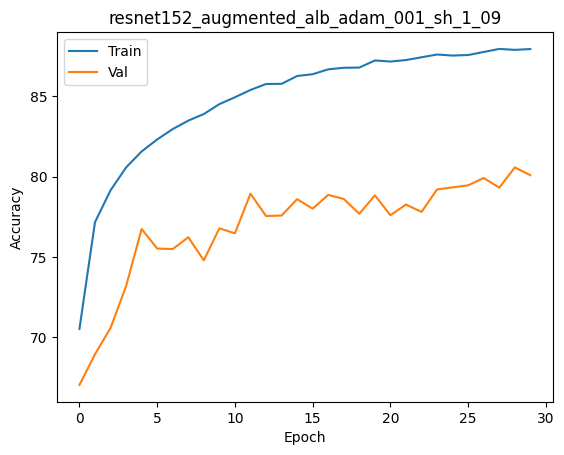

In [406]:
%matplotlib inline
fig, ax = plt.subplots()
ax.plot(train_accuracies, label='Train')
ax.plot(val_accuracies, label='Val')
ax.set_title(model_name)
ax.set(xlabel='Epoch', ylabel='Accuracy')
ax.legend()
plt.show()